In [46]:
from mplfinance.original_flavor import candlestick_ohlc
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import hvplot as hv
from scipy.stats import pearsonr
from prophet import Prophet
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

plt.style.use('seaborn-v0_8')
sns.set(style="darkgrid")

import warnings
warnings.filterwarnings("ignore")

In [47]:
def plot_candlestick(df, ax=None, fmt="%Y-%m-%d", ylabel = None):
    if ax is None:
        fig, ax = plt.subplots()
    idx_name = df.index.name if df.index.name else 'index'
    dat = df.reset_index()[[idx_name, "Open", "High", "Low", "Close"]]
    dat[idx_name] = dat[idx_name].map(mdates.date2num)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter(fmt))
    plt.xticks(rotation=45)
    _ = candlestick_ohlc(ax, dat.values, width=.6, colorup='g', alpha =1)
    ax.set_xlabel(idx_name)
    ax.set_ylabel(ylabel)
    return ax

In [48]:
def is_normal(test, p_level=0.05):
    _, pval = test
    return 'Normal' if pval > p_level else 'Not Normal'

In [49]:
def get_shares_data(ticker):
    tickerData = yf.Ticker(ticker)
    tickerDF = tickerData.history(period = '1d', start = "2017-1-1")
    return tickerDF.iloc[:, :5]

In [50]:
def correlation_pvalue(df):
    columns = [['Open', 'High'], ['Open', 'Low'], ['Open', 'Close'], ['High', 'Low'], ['High', 'Close'], ['Low', 'Close']]
    for i, j in columns:
        s, p = pearsonr(df[i], df[j])
        print(f"{i} - {j}: correlation = {s:.4f}, pvalue = {p}")

In [51]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [52]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [53]:
procter = get_shares_data("PG")
morgan = get_shares_data("JPM")

In [54]:
correlation_pvalue(procter)
print(50*'-')
correlation_pvalue(morgan)

Open - High: correlation = 0.9995, pvalue = 0.0
Open - Low: correlation = 0.9996, pvalue = 0.0
Open - Close: correlation = 0.9992, pvalue = 0.0
High - Low: correlation = 0.9994, pvalue = 0.0
High - Close: correlation = 0.9996, pvalue = 0.0
Low - Close: correlation = 0.9996, pvalue = 0.0
--------------------------------------------------
Open - High: correlation = 0.9993, pvalue = 0.0
Open - Low: correlation = 0.9992, pvalue = 0.0
Open - Close: correlation = 0.9985, pvalue = 0.0
High - Low: correlation = 0.9989, pvalue = 0.0
High - Close: correlation = 0.9993, pvalue = 0.0
Low - Close: correlation = 0.9992, pvalue = 0.0


##### Корреляция между всеми показателями акций близка к единица и статистически значима, поэтому берем только показатель закрытия торгов. Динамика остальных показателей будет схожа.

In [56]:
procter.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
morgan.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)

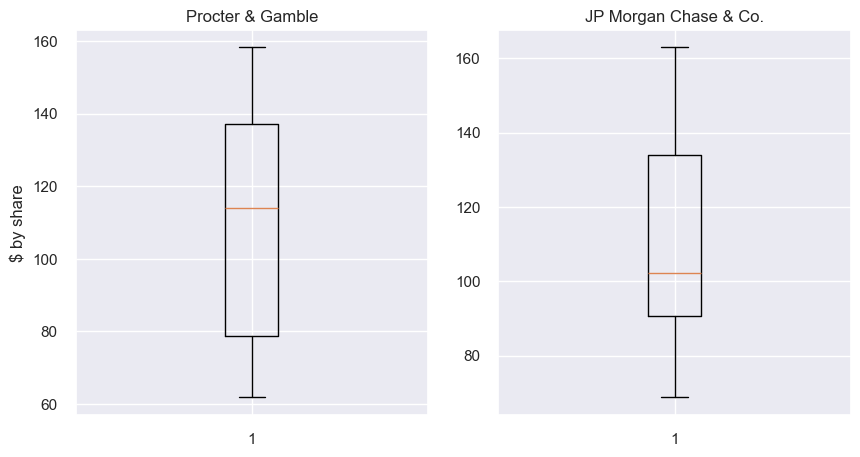

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].boxplot(procter['Close'])
axs[0].set_title('Procter & Gamble')
axs[0].set_ylabel('$ by share')
axs[1].boxplot(morgan['Close'])
axs[1].set_title('JP Morgan Chase & Co.')

plt.show()

##### На данном временном промежутке  Морган Чейз и Проктер энд Гэмбл стабилен (в интерквартильный размах помещается большой диапазон значений, выбросов нет)

In [58]:
closing_prices = morgan.copy()
closing_prices.columns = ['JPM']
closing_prices['PG'] = procter['Close']

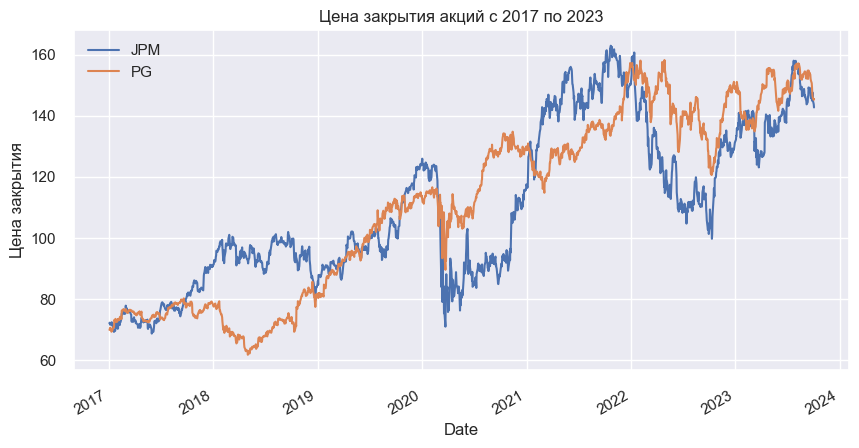

In [59]:
_ = closing_prices.plot(title=f'Цена закрытия акций c 2017 по 2023', ylabel="Цена закрытия", figsize=(10, 5))

##### Нормируем на первое значение в ряду

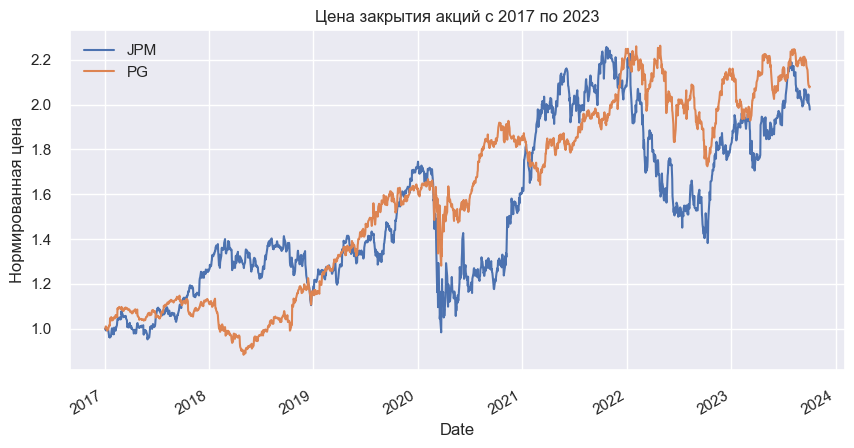

In [60]:
closing_prices_norm = closing_prices.div(closing_prices.iloc[0])
_ = closing_prices_norm.plot(title=f'Цена закрытия акций c 2017 по 2023', ylabel= 'Нормированная цена', figsize=(10, 5))

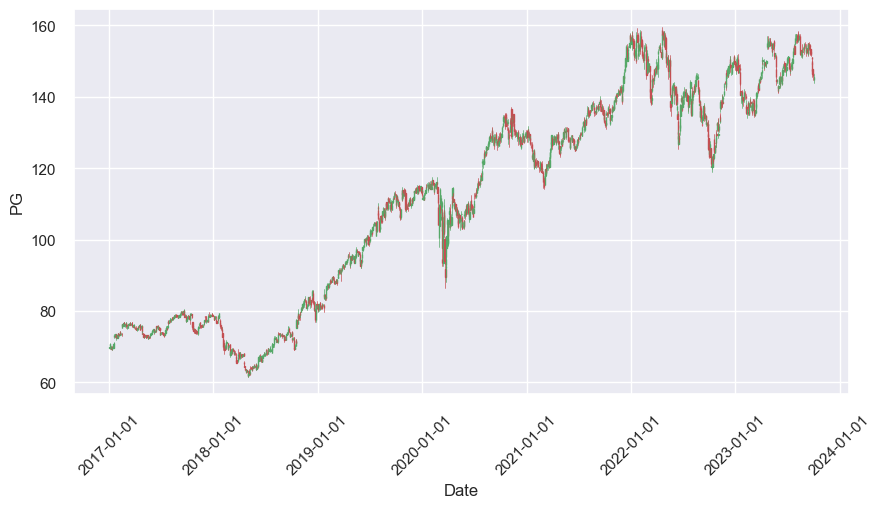

In [61]:
fig = plt.figure(figsize=(10,5))
plot_candlestick(get_shares_data("PG"), fig.subplots(), ylabel="PG")
plt.show()

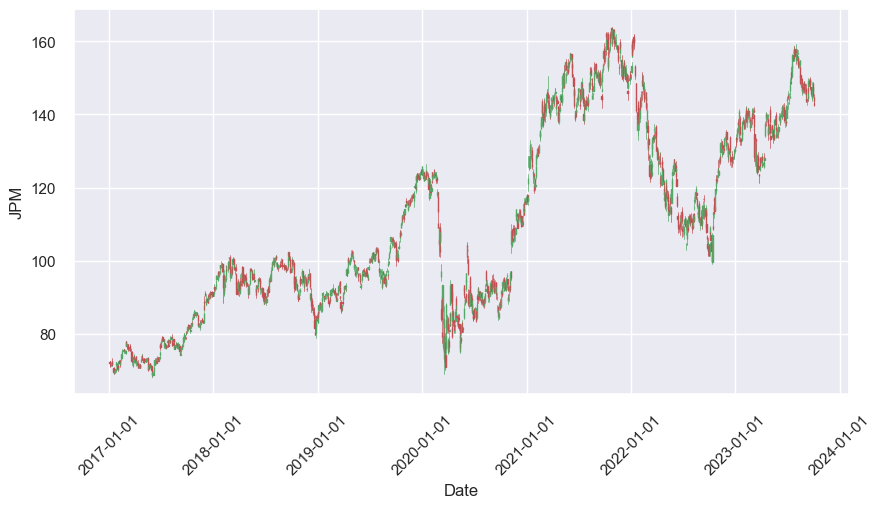

In [62]:
fig = plt.figure(figsize=(10,5))
plot_candlestick(get_shares_data("JPM"), fig.subplots(), ylabel="JPM")
plt.show()

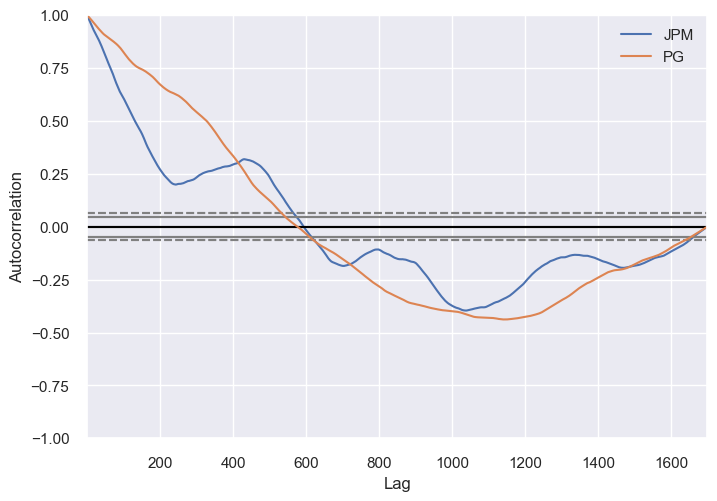

In [67]:
autocorrelation_plot(morgan['Close'], label='JPM')
autocorrelation_plot(procter['Close'], label='PG')
plt.show()

##### Автокорреляция говорит о том, что есть сезонная компонента

In [68]:
morgan_decomposed = seasonal_decompose(morgan, period=250, model='multiplicative')
procter_decomposed = seasonal_decompose(procter, period=250, model='multiplicative')

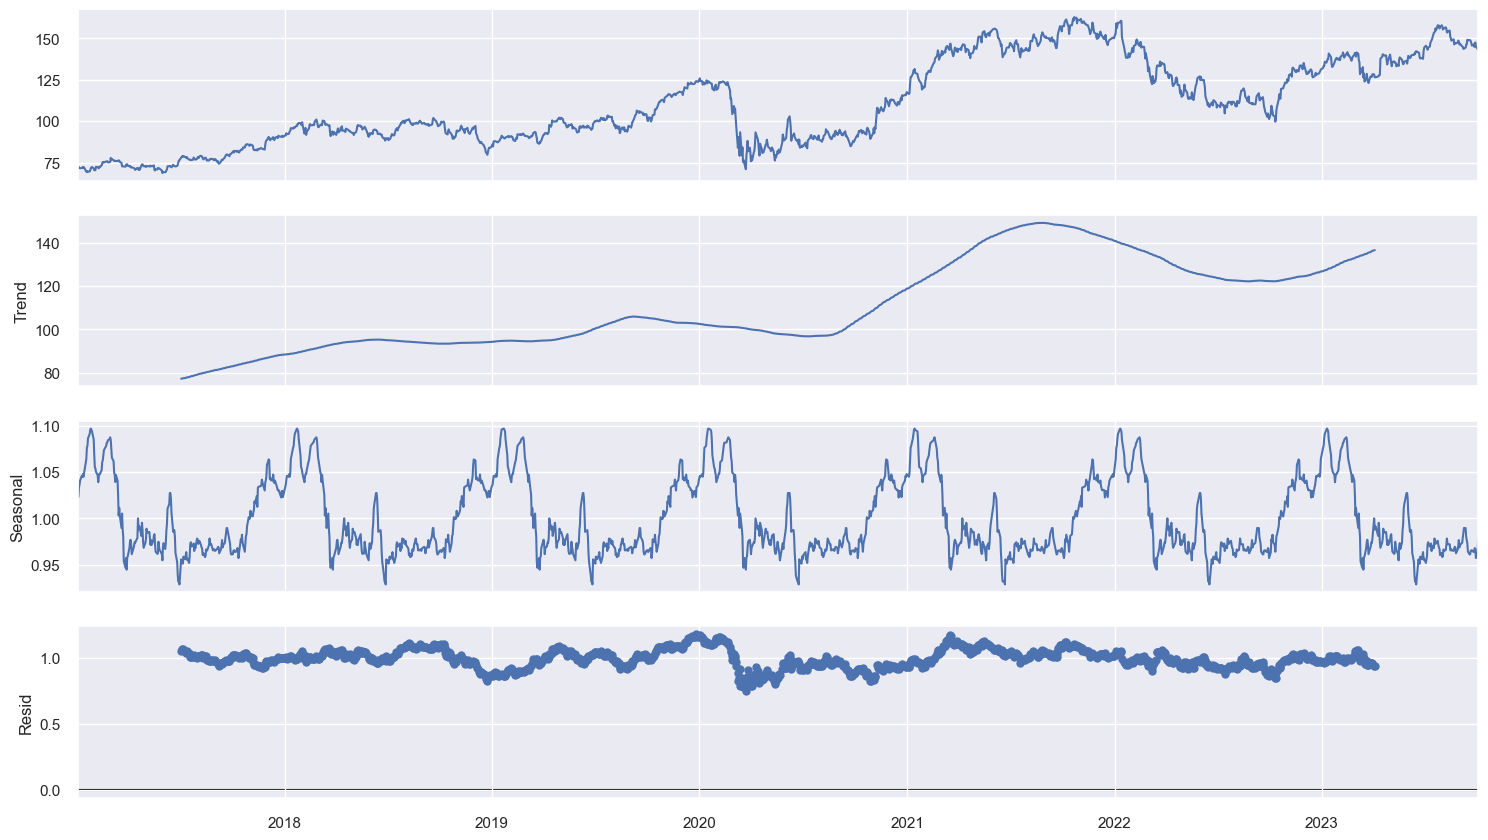

In [69]:
plot = morgan_decomposed.plot()
plot.set_size_inches((16, 9))
fig.tight_layout()
plt.show();

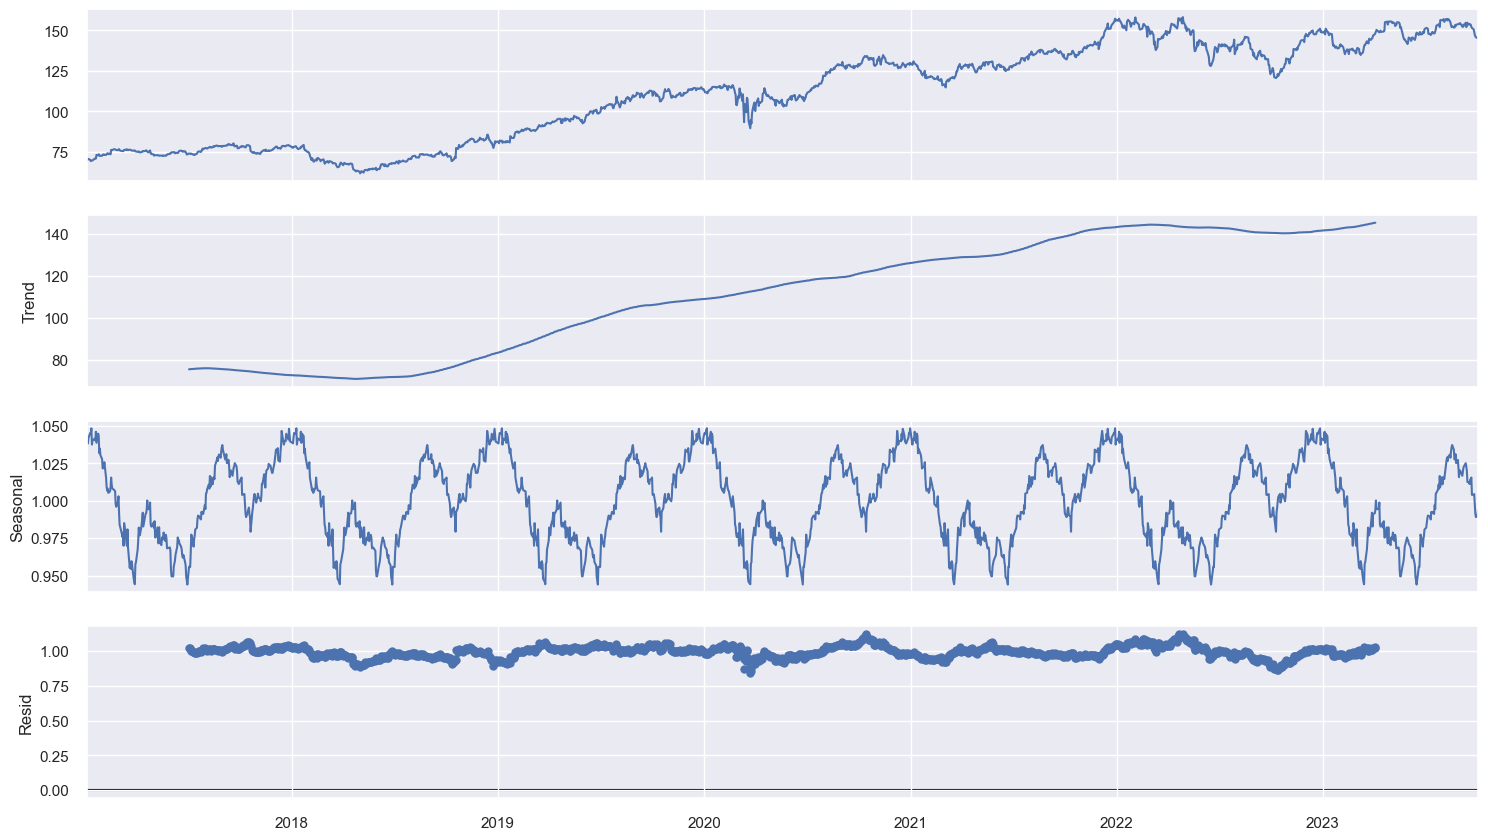

In [70]:
plot = procter_decomposed.plot()
plot.set_size_inches((16, 9))
fig.tight_layout()
plt.show();

##### В обоих временных рядах можно выделить сезонную компоненту. Можно еще заметить сезонное изменение динамики тренда. Особенно это видно для графика компании Морган.

Morgan: Not Normal
Procter: Not Normal


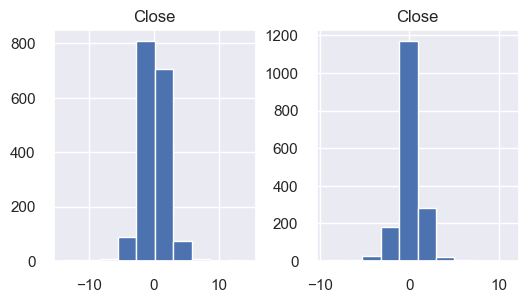

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

print("Morgan: " + is_normal(shapiro(morgan)))
print("Procter: " + is_normal(shapiro(procter)))

_ = morgan.diff().hist(ax=axs[0])
_ = procter.diff().hist(ax=axs[1])

##### Оба ряда не обладают нормальным распределением

Results of Dickey-Fuller Test:
Test Statistic                   -1.617355
p-value                           0.474116
#Lags Used                       13.000000
Number of Observations Used    1685.000000
Critical Value (1%)              -3.434237
Critical Value (5%)              -2.863257
Critical Value (10%)             -2.567684
dtype: float64


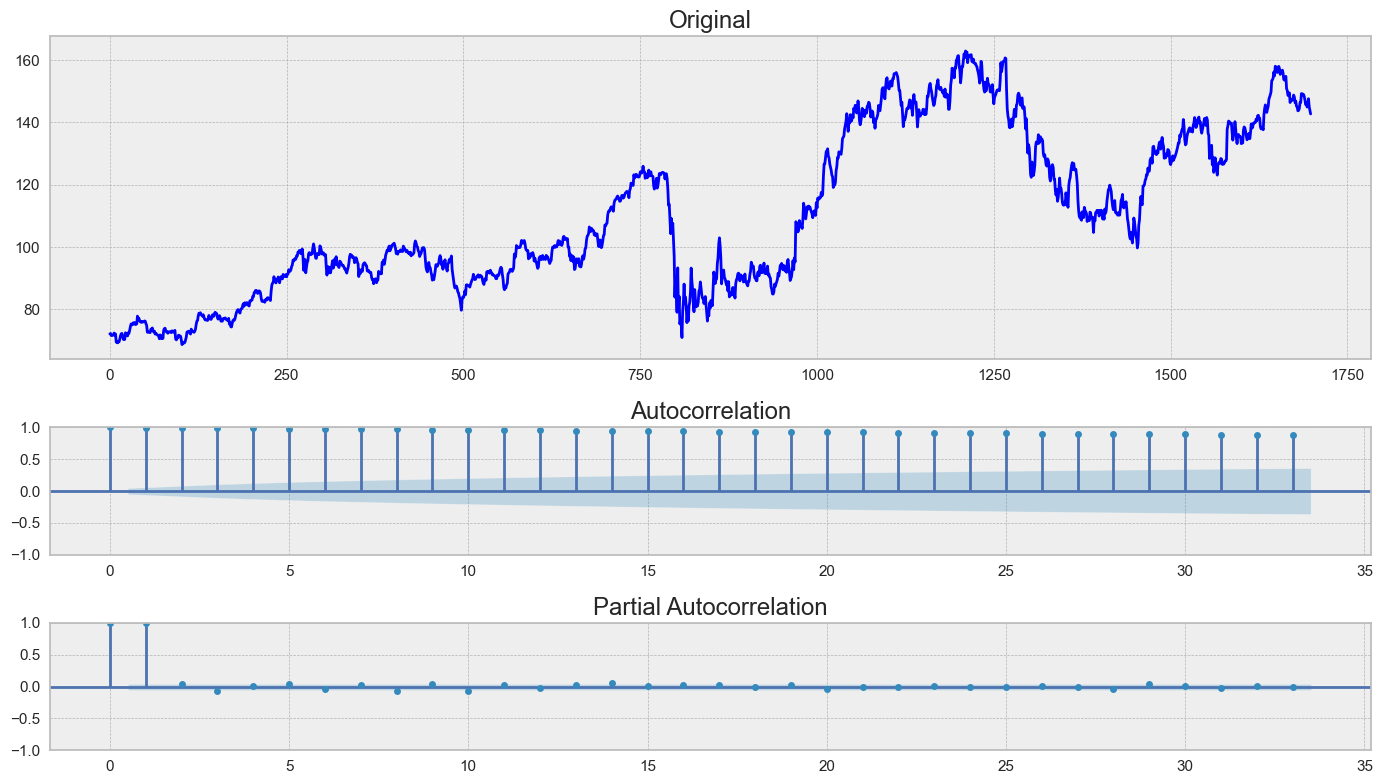

In [72]:
morgan_stat = morgan['Close'].copy().to_numpy()
tsplot(morgan_stat)

In [73]:
morgan_stat = morgan_stat[1:] - morgan_stat[:-1]

Results of Dickey-Fuller Test:
Test Statistic                -1.213647e+01
p-value                        1.689031e-22
#Lags Used                     1.200000e+01
Number of Observations Used    1.685000e+03
Critical Value (1%)           -3.434237e+00
Critical Value (5%)           -2.863257e+00
Critical Value (10%)          -2.567684e+00
dtype: float64


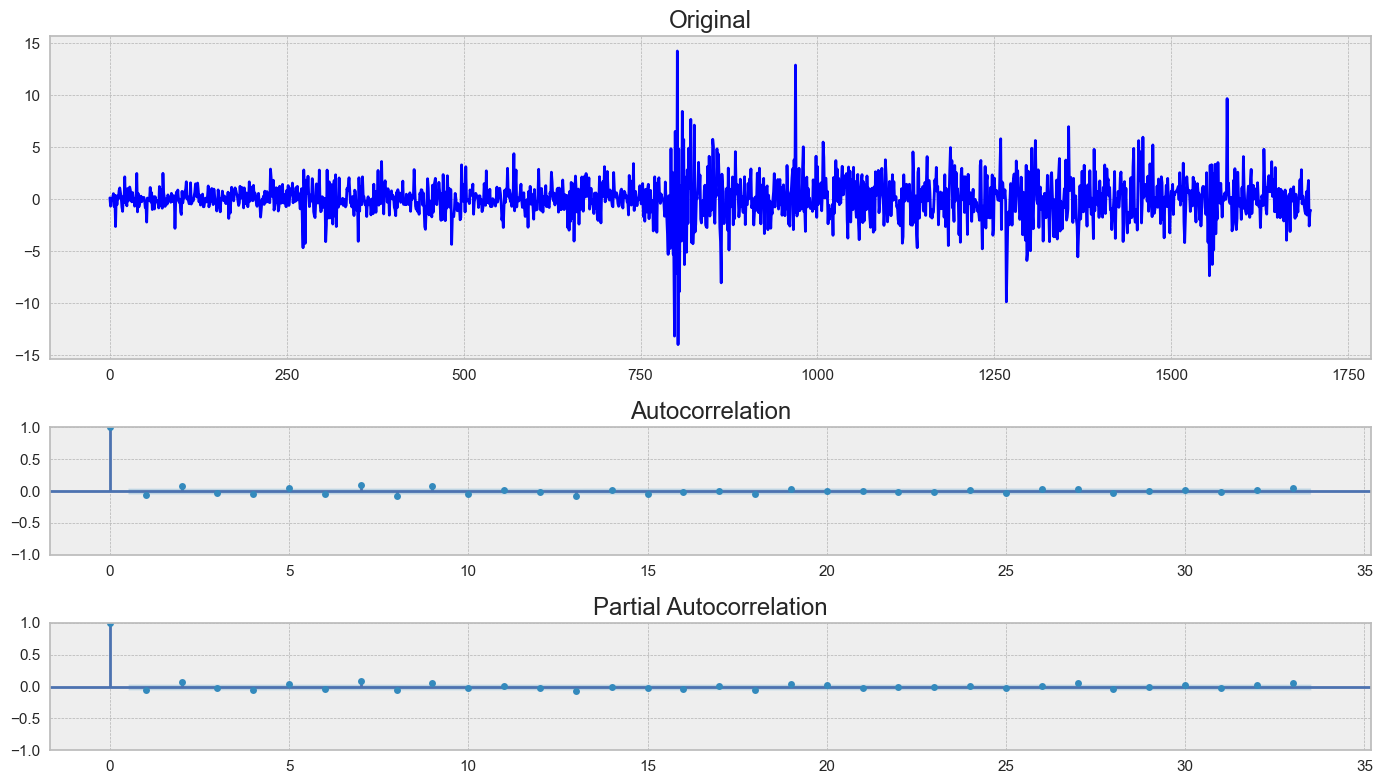

In [74]:
tsplot(morgan_stat)

##### После однократного дифференцирования мы уже можем отвергнуть гипотезу о нестационарности временного ряда.

Results of Dickey-Fuller Test:
Test Statistic                   -1.112394
p-value                           0.710104
#Lags Used                        9.000000
Number of Observations Used    1689.000000
Critical Value (1%)              -3.434228
Critical Value (5%)              -2.863253
Critical Value (10%)             -2.567682
dtype: float64


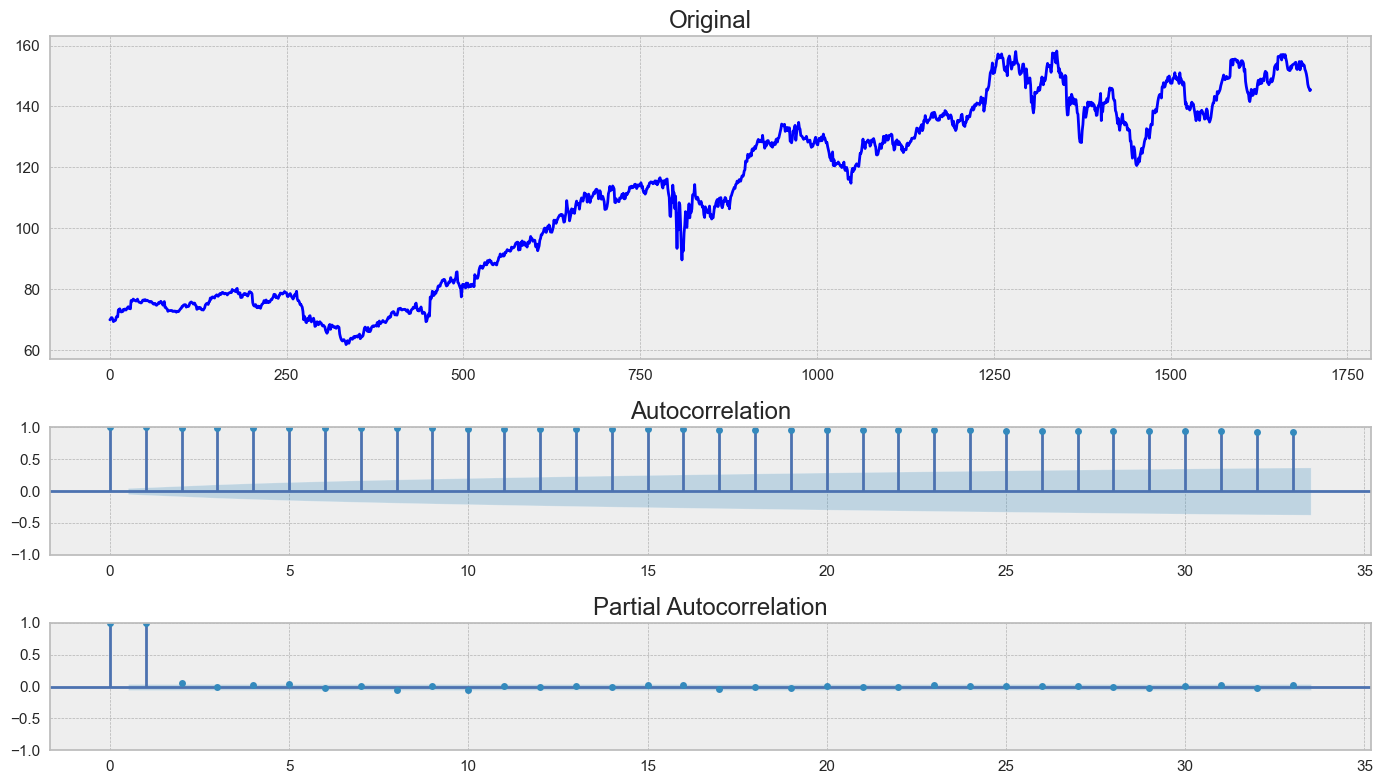

In [75]:
procter_stat = procter['Close'].copy().to_numpy()
tsplot(procter_stat)

In [76]:
procter_stat = procter_stat[1:] - procter_stat[:-1]

Results of Dickey-Fuller Test:
Test Statistic                -1.260821e+01
p-value                        1.677625e-23
#Lags Used                     8.000000e+00
Number of Observations Used    1.689000e+03
Critical Value (1%)           -3.434228e+00
Critical Value (5%)           -2.863253e+00
Critical Value (10%)          -2.567682e+00
dtype: float64


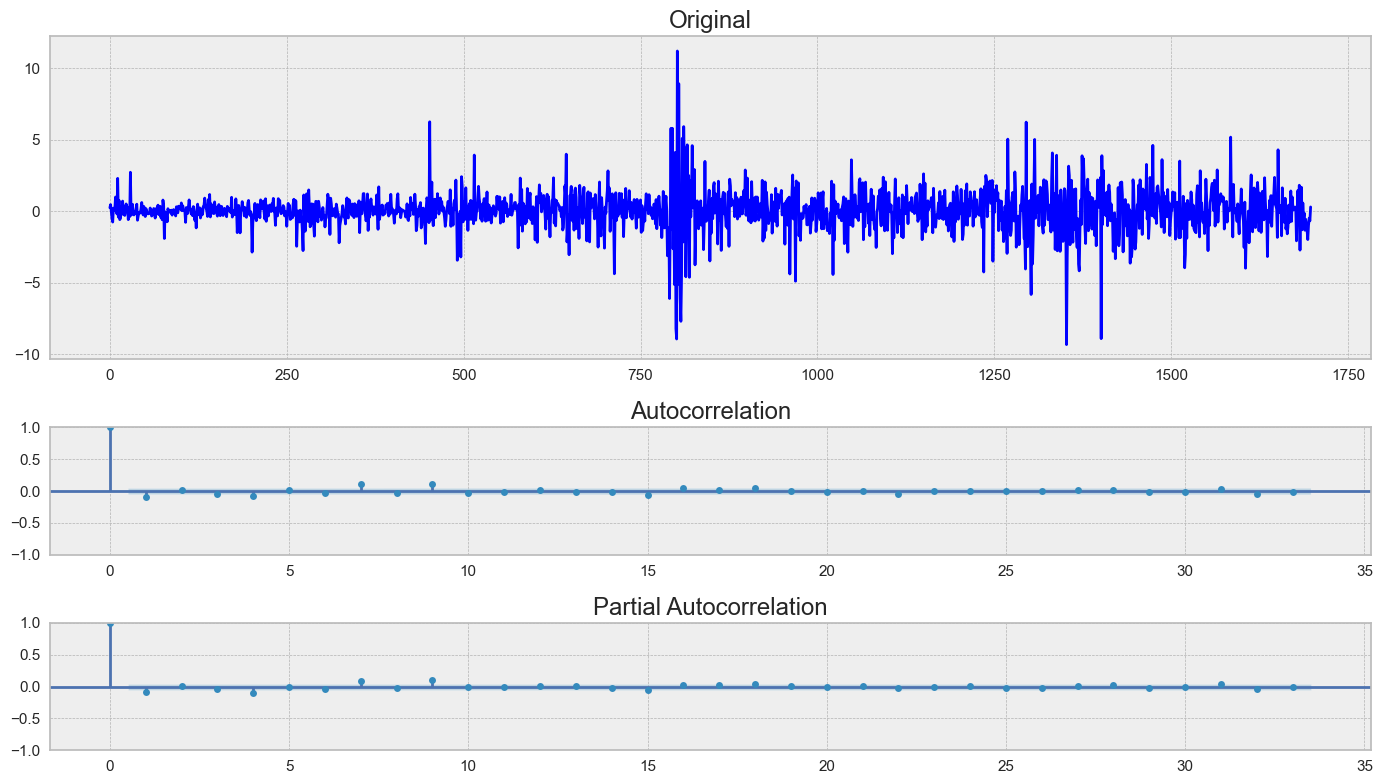

In [77]:
tsplot(procter_stat)

##### Снова одного дифференцирования хватило, чтобы отвергнуть нулевую гипотезу о нестационарности ряда.

## Моделирование временного ряда

##### Facebook Prophet была выбрана потому что это самая удобная библиотека для работы с временными рядам, которая дает хорошие результаты.

In [78]:
df = procter.copy()
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'].dt.strftime('%Y/%m/%d'))
df.columns = ['ds', 'y']

In [84]:
# import time
# predictions = [22, 66, 125, 250]
# for i in predictions:
#     train_df = df[:-i]

#     model = Prophet()
#     model.fit(train_df)

#     # future = model.make_future_dataframe(periods=i)

#     forecast = model.predict(model.make_future_dataframe(periods=i))

#     error = mean_absolute_percentage_error(df[-i:]['y'], forecast[-i:]['yhat'])
#     print("Mean absolute percentage error {0:.2f}%".format(error))
#     _ = model.plot(forecast)
#     time.sleep(3)

In [86]:
predictions_month = 22
predictions_quarter = 66
predictions_half_year = 125
predictions_year = 250

In [87]:
train_df_month = df[:-predictions_month]
train_df_quarter = df[:-predictions_quarter]
train_df_half_year = df[:-predictions_half_year]
train_df_year = df[:-predictions_year]

04:05:39 - cmdstanpy - INFO - Chain [1] start processing
04:05:39 - cmdstanpy - INFO - Chain [1] done processing


Mean absolute percentage error 2.75%


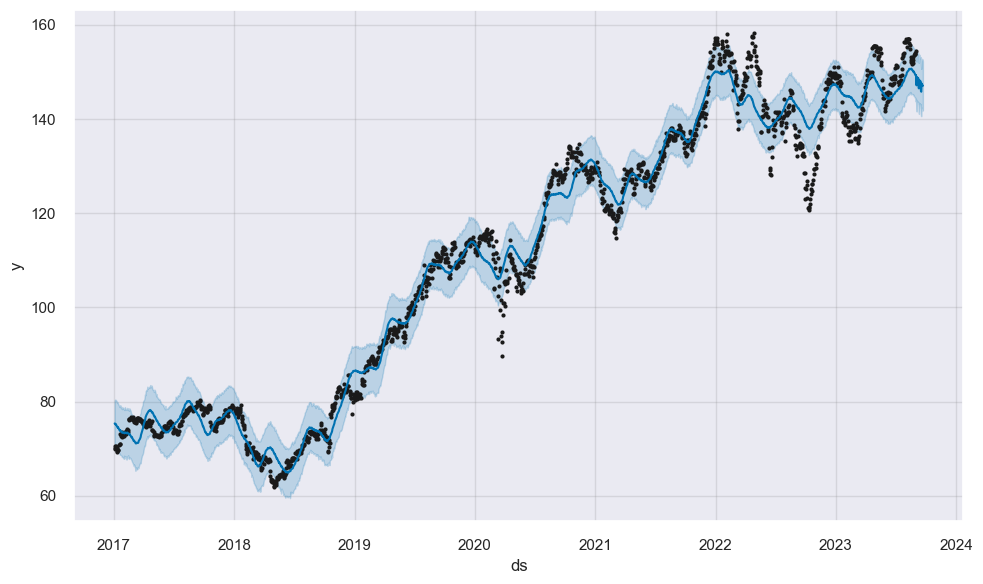

In [89]:
model = Prophet()
model.fit(train_df_month)

future = model.make_future_dataframe(periods=predictions_month)
forecast = model.predict(future)

error = mean_absolute_percentage_error(df[-predictions_month:]['y'], forecast[-predictions_month:]['yhat'])
print("Mean absolute percentage error {0:.2f}%".format(error))
_ = model.plot(forecast)

04:06:15 - cmdstanpy - INFO - Chain [1] start processing
04:06:15 - cmdstanpy - INFO - Chain [1] done processing


Mean absolute percentage error 7.85%


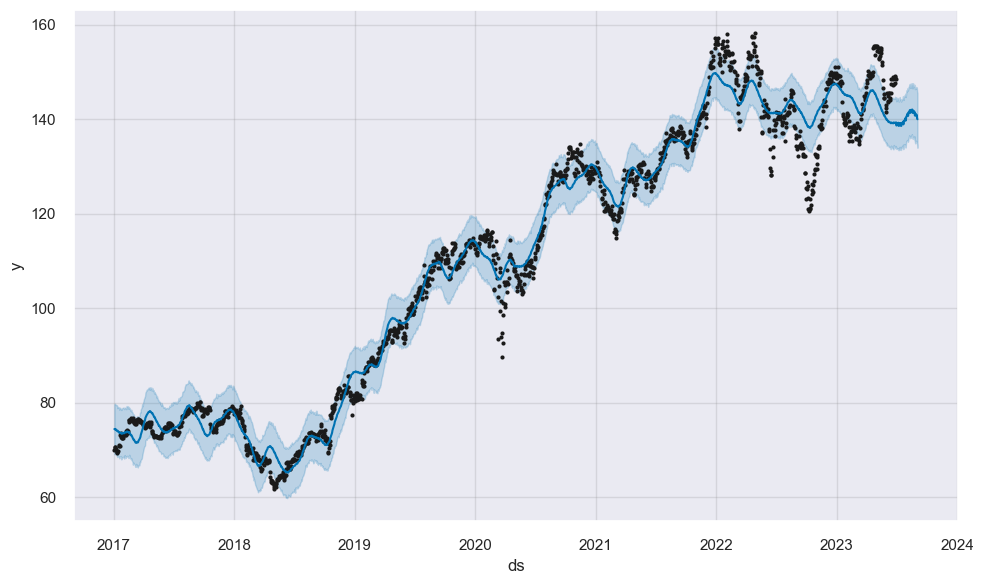

In [91]:
model = Prophet()
model.fit(train_df_quarter)

future = model.make_future_dataframe(periods=predictions_quarter)
forecast = model.predict(future)

error = mean_absolute_percentage_error(df[-predictions_quarter:]['y'], forecast[-predictions_quarter:]['yhat'])
print("Mean absolute percentage error {0:.2f}%".format(error))
_ = model.plot(forecast)

04:06:56 - cmdstanpy - INFO - Chain [1] start processing
04:06:56 - cmdstanpy - INFO - Chain [1] done processing


Mean absolute percentage error 11.74%


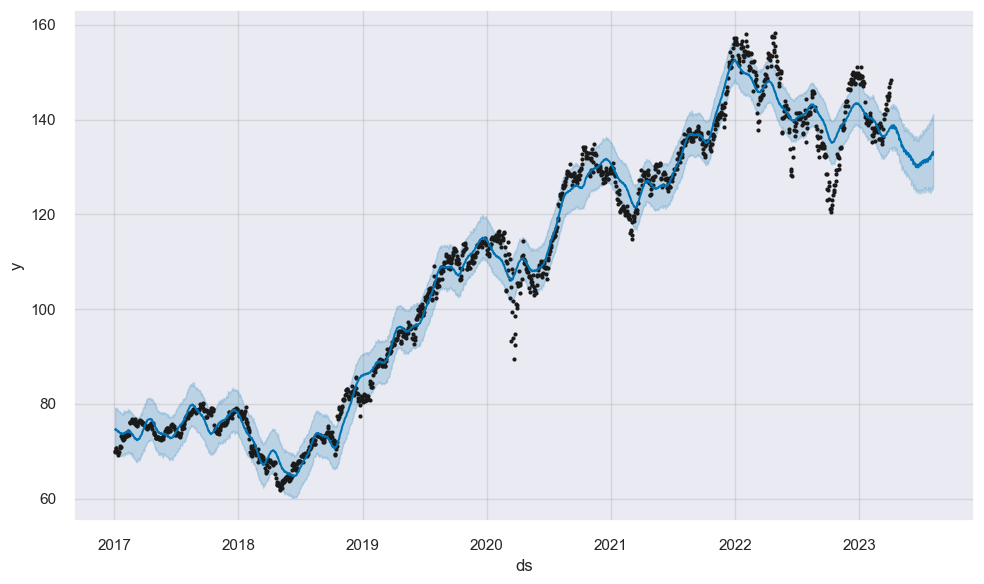

In [92]:
model = Prophet()
model.fit(train_df_half_year)

future = model.make_future_dataframe(periods=predictions_half_year)
forecast = model.predict(future)

error = mean_absolute_percentage_error(df[-predictions_half_year:]['y'], forecast[-predictions_half_year:]['yhat'])
print("Mean absolute percentage error {0:.2f}%".format(error))
_ = model.plot(forecast)

04:07:25 - cmdstanpy - INFO - Chain [1] start processing
04:07:26 - cmdstanpy - INFO - Chain [1] done processing


Mean absolute percentage error 5.04%


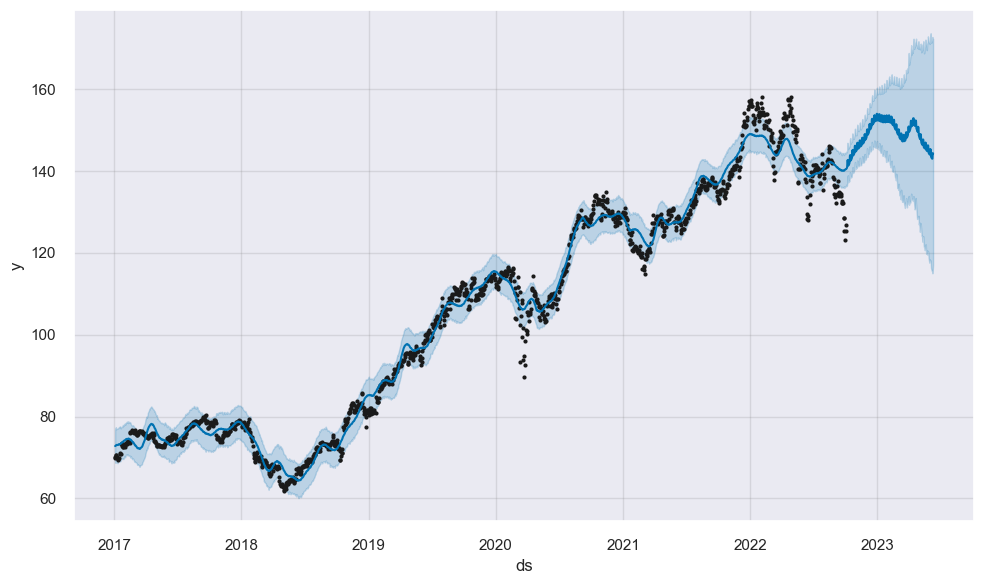

In [93]:
model = Prophet()
model.fit(train_df_year)

future = model.make_future_dataframe(periods=predictions_year)
forecast = model.predict(future)

error = mean_absolute_percentage_error(df[-predictions_year:]['y'], forecast[-predictions_year:]['yhat'])
print("Mean absolute percentage error {0:.2f}%".format(error))
_ = model.plot(forecast)

##### Худший результат был показан для полугодового интервала, скорее всего потому, что наш временной ряд не имеент сезонности по такому временному промежутку.